# INTRODUCTION

## Overview

Natural Language Processing is a complex field which is hypothesised to be part of AI-complete set of problems, implying that the difficulty of these computational problems is equivalent to that of solving the central artificial intelligence problem of making computers as intelligent as people. With over 90% of data ever generated being produced in the last 2 years and with a great proportion being human generated unstructured text there is an ever increasing need to advance the field of Natural Language Processing.

Recent UK Government proposal to have measures to regulate social media companies over harmful content, including "substantial" fines and the ability to block services that do not stick to the rules is an example of the regulamentary need to better manage the content that is being generated by users.

Other initiatives like ​Riot Games​' work aimed to predict and reform toxic player behaviour during games is another example of this effort to understand the content being generated by users and moderate toxic content.
However, as highlighted by the Kaggle competition ​Jigsaw unintended bias in toxicity classification​, existing models suffer from unintended bias where models might predict high likelihood of toxicity for content containing certain words (e.g. "gay") even when those comments were not actually toxic (such as "I am a gay woman"), leaving machine only classification models still sub-standard.

The outcome of our analysis is the type of algorithm that companies will use to define what is free speech and what shouldn't be tolerated in a discussion. This challenge actually starts with how the training dataset was produced: Multiple people (annotators) read thousands of comments and defined if those comments were offensive or not. Where is the trick? They disagreed in many of them. Having tools that are able to flag up toxic content without suffering from unintended bias is of paramount importance to preserve Internet's fairness and freedom of speech

## Dataset

At the end of 2017 the Civil Comments platform shut down and chose make their ~2m public comments from their platform available in a lasting open archive so that researchers could understand and improve civility in online conversations for years to come. Jigsaw sponsored this effort and extended annotation of this data by human raters for various toxic conversational attributes.

In the data supplied for this competition, the text of the individual comment is found in the comment_text column. Each comment in Train has a toxicity label (target), and models should predict the target toxicity for the Test data. This attribute (and all others) are fractional values which represent the fraction of human raters who believed the attribute applied to the given comment.

For evaluation, test set examples with target >= 0.5 will be considered to be in the positive class (toxic).


In [1]:
import warnings
warnings.filterwarnings('ignore')



In [2]:
from __future__ import print_function

import os
import sys

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.plotly as py
import missingno as msno


import numpy as np
import pandas as pd
from scipy import stats
import spacy
from sklearn.decomposition import PCA

from wordcloud import WordCloud ,STOPWORDS

import watermark

from tqdm import tqdm_notebook

from wordcloud import WordCloud, STOPWORDS
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from gensim import corpora, models
from sklearn.model_selection import train_test_split,cross_val_score
import operator
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
#lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])#
#nltk.download('wordnet')

%load_ext watermark

import random

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler,robust_scale,MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn import metrics

from nltk.tokenize import TweetTokenizer,sent_tokenize, word_tokenize 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D, add
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks,Sequential
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam



PROJ_ROOT = os.path.join(os.pardir)

#print(os.path.abspath(PROJ_ROOT))

C:\Users\Parth\Anaconda3\envs\python3\lib\site-packages\smart_open\ssh.py:34: UserWarning:

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress

C:\Users\Parth\Anaconda3\envs\python3\lib\site-packages\gensim\utils.py:1197: UserWarning:

detected Windows; aliasing chunkize to chunkize_serial

Using TensorFlow backend.


In [3]:
train= pd.read_csv('../Data/train.csv')
#test= pd.read_csv('../Data/test.csv')


In [4]:
train['target'] = np.where(train['target'] >= 0.5, True, False)    

In [5]:
train_df=train

In [6]:
train_df['Is_toxic'] =  train_df['target'].apply(lambda x: "Toxic" if x>=0.5 else "NonToxic")
Nontoxic_df = train_df.loc[train_df['Is_toxic'] == 'NonToxic']
#Nontoxic_df = Nontoxic_df.head(481113)
#Nontoxic_df = Nontoxic_df.head(30000)

toxic_df = train_df.loc[train_df['Is_toxic'] == 'Toxic']
#toxic_df = toxic_df.head(10000)
#del final_df
final_df = pd.concat([Nontoxic_df,toxic_df])
#Nontoxic_df.append(toxic_df) 
#len(final_df)
#dir()
train=final_df
del Nontoxic_df
del toxic_df
del train_df
del final_df

In [7]:
train_temp, test_temp = train_test_split(train, test_size=0.1, stratify=train['target'])

In [8]:
#identity_columns = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
#for col in identity_columns + ['target']:
print(train_temp.shape)
print(test_temp.shape)

(562902, 46)
(62545, 46)


In [9]:
y_test = test_temp['target']

In [10]:
#Split train in train and validate
train_df, valid_df = train_test_split(train_temp, test_size=0.33, stratify=train_temp['target'])
test_df=test_temp
#train_df=train_df[:250000]
train_df=train_df
train_df.loc[:,'set_']="train"
valid_df.loc[:,'set_']="valid"
test_df.loc[:,'set_']="test"

train_df, valid_df = train_test_split(train_df, test_size=0.33, stratify=train['target'])
#test_df=null
#train_df=train_df[:500000]
#train_df=train_df

train_df.loc[:,'set_']="train"
valid_df.loc[:,'set_']="valid"
#test_df.loc[:,'set_']="test"

In [11]:
#Set_indices=train_df.loc[:,'set_'][:500000]
Set_indices=train_df.loc[:,'set_']
Set_indices=Set_indices.append(valid_df.loc[:,'set_'])
Set_indices=Set_indices.append(test_df.loc[:,'set_'])


#y_train = train_df['target'][:500000]
y_train = train_df['target']
y_valid = valid_df['target']

#Set_indices_labels=train_df.loc[:,'set_'][:500000]
Set_indices_labels=train_df.loc[:,'set_']
Set_indices_labels=Set_indices_labels.append(valid_df.loc[:,'set_'])



In [12]:
texts=train_df['comment_text']
texts=texts.append(valid_df['comment_text'])
texts=texts.append(test_df['comment_text'])

print(texts.shape)

labels=train_df['target']
labels=labels.append(valid_df['target'])

print(labels.shape)

(625447,)
(562902,)


In [13]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    from tensorflow import set_random_seed
    set_random_seed(2)

seed_everything()

In [14]:
train_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,Is_toxic,set_
131562,402962,False,Glad they are doing this. All too often -- as ...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0,0,0,0,0,0.0,0,4,NonToxic,train
240422,537507,False,I can only hope that Kurtz was speaking code t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,10,0,0.0,4,6,NonToxic,train
1161267,5535661,True,"Arrest his mother for terrorism too, for brai...",0.3,0.0,0.5,0.4,0.1,0.0,0.0,...,0,0,0,0,0,0.0,10,10,Toxic,train
548068,913670,True,"Actually, you are wrong. Is it a right or pri...",0.0,0.0,0.0,0.5,0.0,0.0,0.0,...,0,0,0,6,3,0.1,6,10,Toxic,train
37510,287664,False,It's really hard to wrap my thoughts around ho...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,3,0,0.0,10,4,NonToxic,train


In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 150
max_words = 90000
embedding_size=300
lr = 1e-3
lr_d = 0


tokenizer = Tokenizer(num_words=max_words)


In [16]:
tokenizer.fit_on_texts(texts)


In [17]:
sequences = tokenizer.texts_to_sequences(texts)

In [18]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 216677 unique tokens.
Shape of data tensor: (625447, 150)
Shape of label tensor: (562902,)


In [19]:
x_train = data[Set_indices == "train"]
x_val = data[Set_indices == "valid"]
x_test = data[Set_indices == "test"]


y_train = labels[Set_indices_labels == "train"]
y_val = labels[Set_indices_labels == "valid"]

print('Shape of train tensor:', x_train.shape)
print('Shape of validate tensor:', x_val.shape)
print('Shape of test tensor:', x_val.shape)

Shape of train tensor: (377144, 150)
Shape of validate tensor: (185758, 150)
Shape of test tensor: (185758, 150)


In [20]:
glove_dir = '../glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'),encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [21]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))


In [22]:
embedding_matrix.shape

(90000, 100)

In [23]:
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        #print(embedding_vector)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
         #   print(embedding_matrix)

In [24]:
embedding_matrix.shape

(90000, 100)

In [25]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.layers[0].set_weights([embedding_matrix])
#model.layers[0].trainable = False

#model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=lr, decay=lr_d), metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          9000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                480032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 9,480,065
Trainable params: 9,480,065
Non-trainable params: 0
_________________________________________________________________


In [26]:
#model.layers[2].get_weights()

In [27]:
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=1024,
                    validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 377144 samples, validate on 185758 samples
Epoch 1/20
377144/377144 [==============================] - ETA: 5:18 - loss: 0.7968 - acc: 0.314 - ETA: 1:52 - loss: 0.7849 - acc: 0.618 - ETA: 1:11 - loss: 0.6995 - acc: 0.679 - ETA: 54s - loss: 0.6625 - acc: 0.704 - ETA: 44s - loss: 0.6349 - acc: 0.72 - ETA: 37s - loss: 0.6132 - acc: 0.73 - ETA: 33s - loss: 0.6036 - acc: 0.73 - ETA: 30s - loss: 0.5961 - acc: 0.74 - ETA: 27s - loss: 0.5879 - acc: 0.74 - ETA: 25s - loss: 0.5827 - acc: 0.74 - ETA: 24s - loss: 0.5779 - acc: 0.74 - ETA: 22s - loss: 0.5721 - acc: 0.74 - ETA: 21s - loss: 0.5662 - acc: 0.74 - ETA: 20s - loss: 0.5616 - acc: 0.74 - ETA: 19s - loss: 0.5578 - acc: 0.75 - ETA: 19s - loss: 0.5527 - acc: 0.75 - ETA: 18s - loss: 0.5489 - acc: 0.75 - ETA: 17s - loss: 0.5460 - acc: 0.75 - ETA: 17s - loss: 0.5425 - acc: 0.75 - ETA: 16s - loss: 0.5394 - acc: 0.75 - ETA: 16s - loss: 0.5359 - acc: 0.75 - ETA: 16s - loss: 0.5331 - acc: 0.75

377144/377144 [==============================] - ETA: 15s - loss: 0.2587 - acc: 0.89 - ETA: 13s - loss: 0.2731 - acc: 0.87 - ETA: 12s - loss: 0.2599 - acc: 0.88 - ETA: 12s - loss: 0.2580 - acc: 0.88 - ETA: 12s - loss: 0.2596 - acc: 0.89 - ETA: 11s - loss: 0.2601 - acc: 0.89 - ETA: 11s - loss: 0.2615 - acc: 0.88 - ETA: 11s - loss: 0.2619 - acc: 0.89 - ETA: 11s - loss: 0.2613 - acc: 0.89 - ETA: 11s - loss: 0.2615 - acc: 0.89 - ETA: 11s - loss: 0.2593 - acc: 0.89 - ETA: 11s - loss: 0.2604 - acc: 0.89 - ETA: 11s - loss: 0.2597 - acc: 0.89 - ETA: 11s - loss: 0.2599 - acc: 0.89 - ETA: 11s - loss: 0.2591 - acc: 0.89 - ETA: 10s - loss: 0.2592 - acc: 0.89 - ETA: 10s - loss: 0.2583 - acc: 0.89 - ETA: 10s - loss: 0.2573 - acc: 0.89 - ETA: 10s - loss: 0.2579 - acc: 0.89 - ETA: 10s - loss: 0.2586 - acc: 0.89 - ETA: 10s - loss: 0.2584 - acc: 0.89 - ETA: 10s - loss: 0.2580 - acc: 0.89 - ETA: 10s - loss: 0.2578 - acc: 0.89 - ETA: 10s - loss: 0.2574 - acc: 0.89 - ETA: 10s - loss: 0.2571 - acc: 0.89 - E

377144/377144 [==============================] - ETA: 15s - loss: 0.1796 - acc: 0.93 - ETA: 12s - loss: 0.1893 - acc: 0.92 - ETA: 12s - loss: 0.1890 - acc: 0.92 - ETA: 12s - loss: 0.1939 - acc: 0.92 - ETA: 12s - loss: 0.1932 - acc: 0.92 - ETA: 11s - loss: 0.1928 - acc: 0.92 - ETA: 11s - loss: 0.1912 - acc: 0.92 - ETA: 11s - loss: 0.1897 - acc: 0.92 - ETA: 11s - loss: 0.1900 - acc: 0.92 - ETA: 11s - loss: 0.1886 - acc: 0.92 - ETA: 11s - loss: 0.1890 - acc: 0.92 - ETA: 11s - loss: 0.1889 - acc: 0.92 - ETA: 11s - loss: 0.1872 - acc: 0.92 - ETA: 11s - loss: 0.1867 - acc: 0.92 - ETA: 11s - loss: 0.1871 - acc: 0.92 - ETA: 11s - loss: 0.1866 - acc: 0.92 - ETA: 11s - loss: 0.1855 - acc: 0.92 - ETA: 11s - loss: 0.1860 - acc: 0.92 - ETA: 11s - loss: 0.1860 - acc: 0.92 - ETA: 11s - loss: 0.1866 - acc: 0.92 - ETA: 11s - loss: 0.1863 - acc: 0.92 - ETA: 11s - loss: 0.1863 - acc: 0.92 - ETA: 10s - loss: 0.1873 - acc: 0.92 - ETA: 10s - loss: 0.1874 - acc: 0.92 - ETA: 10s - loss: 0.1873 - acc: 0.92 - E

377144/377144 [==============================] - ETA: 16s - loss: 0.1348 - acc: 0.93 - ETA: 12s - loss: 0.1295 - acc: 0.94 - ETA: 12s - loss: 0.1438 - acc: 0.94 - ETA: 12s - loss: 0.1439 - acc: 0.94 - ETA: 12s - loss: 0.1437 - acc: 0.94 - ETA: 12s - loss: 0.1455 - acc: 0.94 - ETA: 11s - loss: 0.1455 - acc: 0.94 - ETA: 11s - loss: 0.1472 - acc: 0.94 - ETA: 11s - loss: 0.1477 - acc: 0.94 - ETA: 11s - loss: 0.1488 - acc: 0.94 - ETA: 11s - loss: 0.1489 - acc: 0.94 - ETA: 11s - loss: 0.1490 - acc: 0.94 - ETA: 11s - loss: 0.1503 - acc: 0.94 - ETA: 11s - loss: 0.1515 - acc: 0.94 - ETA: 11s - loss: 0.1517 - acc: 0.94 - ETA: 11s - loss: 0.1509 - acc: 0.94 - ETA: 11s - loss: 0.1522 - acc: 0.94 - ETA: 11s - loss: 0.1522 - acc: 0.94 - ETA: 11s - loss: 0.1520 - acc: 0.94 - ETA: 10s - loss: 0.1522 - acc: 0.94 - ETA: 10s - loss: 0.1520 - acc: 0.94 - ETA: 10s - loss: 0.1517 - acc: 0.94 - ETA: 10s - loss: 0.1514 - acc: 0.94 - ETA: 10s - loss: 0.1512 - acc: 0.94 - ETA: 10s - loss: 0.1507 - acc: 0.94 - E

377144/377144 [==============================] - ETA: 14s - loss: 0.1191 - acc: 0.95 - ETA: 12s - loss: 0.1272 - acc: 0.95 - ETA: 12s - loss: 0.1194 - acc: 0.95 - ETA: 12s - loss: 0.1223 - acc: 0.95 - ETA: 11s - loss: 0.1241 - acc: 0.95 - ETA: 11s - loss: 0.1225 - acc: 0.95 - ETA: 11s - loss: 0.1228 - acc: 0.95 - ETA: 11s - loss: 0.1231 - acc: 0.95 - ETA: 11s - loss: 0.1228 - acc: 0.95 - ETA: 11s - loss: 0.1210 - acc: 0.95 - ETA: 11s - loss: 0.1216 - acc: 0.95 - ETA: 11s - loss: 0.1215 - acc: 0.95 - ETA: 11s - loss: 0.1215 - acc: 0.95 - ETA: 11s - loss: 0.1215 - acc: 0.95 - ETA: 11s - loss: 0.1215 - acc: 0.95 - ETA: 11s - loss: 0.1215 - acc: 0.95 - ETA: 11s - loss: 0.1219 - acc: 0.95 - ETA: 10s - loss: 0.1213 - acc: 0.95 - ETA: 10s - loss: 0.1215 - acc: 0.95 - ETA: 10s - loss: 0.1211 - acc: 0.95 - ETA: 10s - loss: 0.1207 - acc: 0.95 - ETA: 10s - loss: 0.1206 - acc: 0.95 - ETA: 10s - loss: 0.1212 - acc: 0.95 - ETA: 10s - loss: 0.1216 - acc: 0.95 - ETA: 10s - loss: 0.1216 - acc: 0.95 - E

377144/377144 [==============================] - ETA: 15s - loss: 0.1081 - acc: 0.96 - ETA: 12s - loss: 0.1017 - acc: 0.96 - ETA: 12s - loss: 0.1005 - acc: 0.96 - ETA: 11s - loss: 0.0968 - acc: 0.96 - ETA: 11s - loss: 0.0998 - acc: 0.96 - ETA: 11s - loss: 0.0997 - acc: 0.96 - ETA: 11s - loss: 0.0979 - acc: 0.96 - ETA: 11s - loss: 0.0970 - acc: 0.96 - ETA: 11s - loss: 0.0951 - acc: 0.96 - ETA: 11s - loss: 0.0961 - acc: 0.96 - ETA: 11s - loss: 0.0990 - acc: 0.96 - ETA: 11s - loss: 0.0991 - acc: 0.96 - ETA: 11s - loss: 0.1000 - acc: 0.96 - ETA: 10s - loss: 0.0999 - acc: 0.96 - ETA: 10s - loss: 0.1005 - acc: 0.96 - ETA: 10s - loss: 0.0998 - acc: 0.96 - ETA: 10s - loss: 0.0999 - acc: 0.96 - ETA: 10s - loss: 0.1001 - acc: 0.96 - ETA: 10s - loss: 0.1003 - acc: 0.96 - ETA: 10s - loss: 0.1002 - acc: 0.96 - ETA: 10s - loss: 0.1004 - acc: 0.96 - ETA: 10s - loss: 0.0999 - acc: 0.96 - ETA: 10s - loss: 0.0994 - acc: 0.96 - ETA: 10s - loss: 0.0991 - acc: 0.96 - ETA: 10s - loss: 0.0991 - acc: 0.96 - E

377144/377144 [==============================] - ETA: 14s - loss: 0.0849 - acc: 0.96 - ETA: 12s - loss: 0.0769 - acc: 0.97 - ETA: 12s - loss: 0.0743 - acc: 0.97 - ETA: 11s - loss: 0.0700 - acc: 0.97 - ETA: 11s - loss: 0.0705 - acc: 0.97 - ETA: 11s - loss: 0.0710 - acc: 0.97 - ETA: 11s - loss: 0.0709 - acc: 0.97 - ETA: 11s - loss: 0.0716 - acc: 0.97 - ETA: 11s - loss: 0.0712 - acc: 0.97 - ETA: 11s - loss: 0.0713 - acc: 0.97 - ETA: 11s - loss: 0.0716 - acc: 0.97 - ETA: 10s - loss: 0.0717 - acc: 0.97 - ETA: 10s - loss: 0.0720 - acc: 0.97 - ETA: 10s - loss: 0.0719 - acc: 0.97 - ETA: 10s - loss: 0.0715 - acc: 0.97 - ETA: 10s - loss: 0.0712 - acc: 0.97 - ETA: 10s - loss: 0.0719 - acc: 0.97 - ETA: 10s - loss: 0.0720 - acc: 0.97 - ETA: 10s - loss: 0.0719 - acc: 0.97 - ETA: 10s - loss: 0.0727 - acc: 0.97 - ETA: 10s - loss: 0.0725 - acc: 0.97 - ETA: 10s - loss: 0.0723 - acc: 0.97 - ETA: 10s - loss: 0.0727 - acc: 0.97 - ETA: 10s - loss: 0.0728 - acc: 0.97 - ETA: 10s - loss: 0.0725 - acc: 0.97 - E

377144/377144 [==============================] - ETA: 15s - loss: 0.0569 - acc: 0.98 - ETA: 12s - loss: 0.0572 - acc: 0.98 - ETA: 12s - loss: 0.0573 - acc: 0.98 - ETA: 11s - loss: 0.0599 - acc: 0.98 - ETA: 11s - loss: 0.0573 - acc: 0.98 - ETA: 11s - loss: 0.0553 - acc: 0.98 - ETA: 11s - loss: 0.0553 - acc: 0.98 - ETA: 11s - loss: 0.0540 - acc: 0.98 - ETA: 11s - loss: 0.0527 - acc: 0.98 - ETA: 11s - loss: 0.0521 - acc: 0.98 - ETA: 11s - loss: 0.0513 - acc: 0.98 - ETA: 11s - loss: 0.0520 - acc: 0.98 - ETA: 11s - loss: 0.0512 - acc: 0.98 - ETA: 11s - loss: 0.0513 - acc: 0.98 - ETA: 10s - loss: 0.0517 - acc: 0.98 - ETA: 10s - loss: 0.0515 - acc: 0.98 - ETA: 10s - loss: 0.0517 - acc: 0.98 - ETA: 10s - loss: 0.0516 - acc: 0.98 - ETA: 10s - loss: 0.0518 - acc: 0.98 - ETA: 10s - loss: 0.0516 - acc: 0.98 - ETA: 10s - loss: 0.0510 - acc: 0.98 - ETA: 10s - loss: 0.0509 - acc: 0.98 - ETA: 10s - loss: 0.0507 - acc: 0.98 - ETA: 10s - loss: 0.0506 - acc: 0.98 - ETA: 10s - loss: 0.0514 - acc: 0.98 - E

377144/377144 [==============================] - ETA: 16s - loss: 0.0329 - acc: 0.99 - ETA: 13s - loss: 0.0326 - acc: 0.99 - ETA: 12s - loss: 0.0383 - acc: 0.98 - ETA: 12s - loss: 0.0405 - acc: 0.98 - ETA: 12s - loss: 0.0418 - acc: 0.98 - ETA: 11s - loss: 0.0430 - acc: 0.98 - ETA: 11s - loss: 0.0438 - acc: 0.98 - ETA: 11s - loss: 0.0427 - acc: 0.98 - ETA: 11s - loss: 0.0421 - acc: 0.98 - ETA: 11s - loss: 0.0418 - acc: 0.98 - ETA: 11s - loss: 0.0415 - acc: 0.98 - ETA: 11s - loss: 0.0409 - acc: 0.98 - ETA: 11s - loss: 0.0414 - acc: 0.98 - ETA: 11s - loss: 0.0408 - acc: 0.98 - ETA: 11s - loss: 0.0404 - acc: 0.98 - ETA: 11s - loss: 0.0402 - acc: 0.98 - ETA: 11s - loss: 0.0402 - acc: 0.98 - ETA: 10s - loss: 0.0398 - acc: 0.98 - ETA: 10s - loss: 0.0395 - acc: 0.98 - ETA: 10s - loss: 0.0393 - acc: 0.98 - ETA: 10s - loss: 0.0390 - acc: 0.98 - ETA: 10s - loss: 0.0390 - acc: 0.98 - ETA: 10s - loss: 0.0387 - acc: 0.98 - ETA: 10s - loss: 0.0387 - acc: 0.98 - ETA: 10s - loss: 0.0386 - acc: 0.98 - E

377144/377144 [==============================] - ETA: 15s - loss: 0.0411 - acc: 0.98 - ETA: 12s - loss: 0.0298 - acc: 0.99 - ETA: 12s - loss: 0.0295 - acc: 0.99 - ETA: 11s - loss: 0.0279 - acc: 0.99 - ETA: 11s - loss: 0.0258 - acc: 0.99 - ETA: 11s - loss: 0.0270 - acc: 0.99 - ETA: 11s - loss: 0.0259 - acc: 0.99 - ETA: 11s - loss: 0.0252 - acc: 0.99 - ETA: 11s - loss: 0.0253 - acc: 0.99 - ETA: 11s - loss: 0.0257 - acc: 0.99 - ETA: 11s - loss: 0.0255 - acc: 0.99 - ETA: 11s - loss: 0.0258 - acc: 0.99 - ETA: 11s - loss: 0.0260 - acc: 0.99 - ETA: 11s - loss: 0.0256 - acc: 0.99 - ETA: 11s - loss: 0.0257 - acc: 0.99 - ETA: 10s - loss: 0.0256 - acc: 0.99 - ETA: 10s - loss: 0.0256 - acc: 0.99 - ETA: 10s - loss: 0.0256 - acc: 0.99 - ETA: 10s - loss: 0.0254 - acc: 0.99 - ETA: 10s - loss: 0.0254 - acc: 0.99 - ETA: 10s - loss: 0.0253 - acc: 0.99 - ETA: 10s - loss: 0.0253 - acc: 0.99 - ETA: 10s - loss: 0.0254 - acc: 0.99 - ETA: 10s - loss: 0.0253 - acc: 0.99 - ETA: 10s - loss: 0.0254 - acc: 0.99 - E

377144/377144 [==============================] - ETA: 15s - loss: 0.0205 - acc: 0.99 - ETA: 12s - loss: 0.0190 - acc: 0.99 - ETA: 12s - loss: 0.0175 - acc: 0.99 - ETA: 12s - loss: 0.0193 - acc: 0.99 - ETA: 11s - loss: 0.0176 - acc: 0.99 - ETA: 11s - loss: 0.0177 - acc: 0.99 - ETA: 11s - loss: 0.0179 - acc: 0.99 - ETA: 11s - loss: 0.0182 - acc: 0.99 - ETA: 11s - loss: 0.0180 - acc: 0.99 - ETA: 11s - loss: 0.0178 - acc: 0.99 - ETA: 11s - loss: 0.0181 - acc: 0.99 - ETA: 11s - loss: 0.0182 - acc: 0.99 - ETA: 11s - loss: 0.0182 - acc: 0.99 - ETA: 10s - loss: 0.0177 - acc: 0.99 - ETA: 10s - loss: 0.0176 - acc: 0.99 - ETA: 10s - loss: 0.0178 - acc: 0.99 - ETA: 10s - loss: 0.0181 - acc: 0.99 - ETA: 10s - loss: 0.0182 - acc: 0.99 - ETA: 10s - loss: 0.0183 - acc: 0.99 - ETA: 10s - loss: 0.0185 - acc: 0.99 - ETA: 10s - loss: 0.0185 - acc: 0.99 - ETA: 10s - loss: 0.0185 - acc: 0.99 - ETA: 10s - loss: 0.0186 - acc: 0.99 - ETA: 10s - loss: 0.0187 - acc: 0.99 - ETA: 10s - loss: 0.0189 - acc: 0.99 - E

377144/377144 [==============================] - ETA: 15s - loss: 0.0085 - acc: 0.99 - ETA: 12s - loss: 0.0137 - acc: 0.99 - ETA: 12s - loss: 0.0169 - acc: 0.99 - ETA: 11s - loss: 0.0162 - acc: 0.99 - ETA: 11s - loss: 0.0156 - acc: 0.99 - ETA: 11s - loss: 0.0143 - acc: 0.99 - ETA: 11s - loss: 0.0139 - acc: 0.99 - ETA: 11s - loss: 0.0134 - acc: 0.99 - ETA: 11s - loss: 0.0132 - acc: 0.99 - ETA: 11s - loss: 0.0128 - acc: 0.99 - ETA: 11s - loss: 0.0124 - acc: 0.99 - ETA: 11s - loss: 0.0126 - acc: 0.99 - ETA: 10s - loss: 0.0128 - acc: 0.99 - ETA: 10s - loss: 0.0130 - acc: 0.99 - ETA: 10s - loss: 0.0127 - acc: 0.99 - ETA: 10s - loss: 0.0128 - acc: 0.99 - ETA: 10s - loss: 0.0129 - acc: 0.99 - ETA: 10s - loss: 0.0127 - acc: 0.99 - ETA: 10s - loss: 0.0125 - acc: 0.99 - ETA: 10s - loss: 0.0122 - acc: 0.99 - ETA: 10s - loss: 0.0121 - acc: 0.99 - ETA: 10s - loss: 0.0120 - acc: 0.99 - ETA: 10s - loss: 0.0119 - acc: 0.99 - ETA: 10s - loss: 0.0120 - acc: 0.99 - ETA: 10s - loss: 0.0120 - acc: 0.99 - E

377144/377144 [==============================] - ETA: 14s - loss: 0.0186 - acc: 0.99 - ETA: 12s - loss: 0.0107 - acc: 0.99 - ETA: 11s - loss: 0.0098 - acc: 0.99 - ETA: 11s - loss: 0.0092 - acc: 0.99 - ETA: 11s - loss: 0.0088 - acc: 0.99 - ETA: 11s - loss: 0.0090 - acc: 0.99 - ETA: 11s - loss: 0.0096 - acc: 0.99 - ETA: 11s - loss: 0.0095 - acc: 0.99 - ETA: 11s - loss: 0.0091 - acc: 0.99 - ETA: 11s - loss: 0.0090 - acc: 0.99 - ETA: 10s - loss: 0.0086 - acc: 0.99 - ETA: 10s - loss: 0.0083 - acc: 0.99 - ETA: 10s - loss: 0.0084 - acc: 0.99 - ETA: 10s - loss: 0.0081 - acc: 0.99 - ETA: 10s - loss: 0.0082 - acc: 0.99 - ETA: 10s - loss: 0.0085 - acc: 0.99 - ETA: 10s - loss: 0.0086 - acc: 0.99 - ETA: 10s - loss: 0.0084 - acc: 0.99 - ETA: 10s - loss: 0.0085 - acc: 0.99 - ETA: 10s - loss: 0.0087 - acc: 0.99 - ETA: 10s - loss: 0.0086 - acc: 0.99 - ETA: 10s - loss: 0.0085 - acc: 0.99 - ETA: 10s - loss: 0.0087 - acc: 0.99 - ETA: 10s - loss: 0.0087 - acc: 0.99 - ETA: 9s - loss: 0.0086 - acc: 0.9983 - 

377144/377144 [==============================] - ETA: 15s - loss: 0.0061 - acc: 0.99 - ETA: 12s - loss: 0.0105 - acc: 0.99 - ETA: 11s - loss: 0.0084 - acc: 0.99 - ETA: 11s - loss: 0.0094 - acc: 0.99 - ETA: 11s - loss: 0.0093 - acc: 0.99 - ETA: 11s - loss: 0.0087 - acc: 0.99 - ETA: 11s - loss: 0.0090 - acc: 0.99 - ETA: 11s - loss: 0.0085 - acc: 0.99 - ETA: 11s - loss: 0.0081 - acc: 0.99 - ETA: 11s - loss: 0.0080 - acc: 0.99 - ETA: 10s - loss: 0.0078 - acc: 0.99 - ETA: 10s - loss: 0.0078 - acc: 0.99 - ETA: 10s - loss: 0.0076 - acc: 0.99 - ETA: 10s - loss: 0.0073 - acc: 0.99 - ETA: 10s - loss: 0.0070 - acc: 0.99 - ETA: 10s - loss: 0.0069 - acc: 0.99 - ETA: 10s - loss: 0.0068 - acc: 0.99 - ETA: 10s - loss: 0.0068 - acc: 0.99 - ETA: 10s - loss: 0.0070 - acc: 0.99 - ETA: 10s - loss: 0.0070 - acc: 0.99 - ETA: 10s - loss: 0.0070 - acc: 0.99 - ETA: 10s - loss: 0.0071 - acc: 0.99 - ETA: 10s - loss: 0.0069 - acc: 0.99 - ETA: 10s - loss: 0.0068 - acc: 0.99 - ETA: 10s - loss: 0.0068 - acc: 0.99 - E

377144/377144 [==============================] - ETA: 15s - loss: 0.0043 - acc: 0.99 - ETA: 12s - loss: 0.0091 - acc: 0.99 - ETA: 12s - loss: 0.0081 - acc: 0.99 - ETA: 11s - loss: 0.0067 - acc: 0.99 - ETA: 11s - loss: 0.0064 - acc: 0.99 - ETA: 11s - loss: 0.0063 - acc: 0.99 - ETA: 11s - loss: 0.0059 - acc: 0.99 - ETA: 11s - loss: 0.0056 - acc: 0.99 - ETA: 11s - loss: 0.0055 - acc: 0.99 - ETA: 11s - loss: 0.0054 - acc: 0.99 - ETA: 11s - loss: 0.0051 - acc: 0.99 - ETA: 10s - loss: 0.0049 - acc: 0.99 - ETA: 10s - loss: 0.0052 - acc: 0.99 - ETA: 10s - loss: 0.0050 - acc: 0.99 - ETA: 10s - loss: 0.0049 - acc: 0.99 - ETA: 10s - loss: 0.0048 - acc: 0.99 - ETA: 10s - loss: 0.0051 - acc: 0.99 - ETA: 10s - loss: 0.0051 - acc: 0.99 - ETA: 10s - loss: 0.0051 - acc: 0.99 - ETA: 10s - loss: 0.0053 - acc: 0.99 - ETA: 10s - loss: 0.0055 - acc: 0.99 - ETA: 10s - loss: 0.0055 - acc: 0.99 - ETA: 10s - loss: 0.0054 - acc: 0.99 - ETA: 10s - loss: 0.0054 - acc: 0.99 - ETA: 10s - loss: 0.0054 - acc: 0.99 - E

377144/377144 [==============================] - ETA: 15s - loss: 0.0033 - acc: 0.99 - ETA: 12s - loss: 0.0065 - acc: 0.99 - ETA: 12s - loss: 0.0064 - acc: 0.99 - ETA: 11s - loss: 0.0061 - acc: 0.99 - ETA: 11s - loss: 0.0059 - acc: 0.99 - ETA: 11s - loss: 0.0056 - acc: 0.99 - ETA: 11s - loss: 0.0052 - acc: 0.99 - ETA: 11s - loss: 0.0052 - acc: 0.99 - ETA: 11s - loss: 0.0055 - acc: 0.99 - ETA: 11s - loss: 0.0052 - acc: 0.99 - ETA: 11s - loss: 0.0053 - acc: 0.99 - ETA: 11s - loss: 0.0051 - acc: 0.99 - ETA: 11s - loss: 0.0050 - acc: 0.99 - ETA: 11s - loss: 0.0049 - acc: 0.99 - ETA: 11s - loss: 0.0048 - acc: 0.99 - ETA: 10s - loss: 0.0047 - acc: 0.99 - ETA: 10s - loss: 0.0047 - acc: 0.99 - ETA: 10s - loss: 0.0048 - acc: 0.99 - ETA: 10s - loss: 0.0048 - acc: 0.99 - ETA: 10s - loss: 0.0047 - acc: 0.99 - ETA: 10s - loss: 0.0049 - acc: 0.99 - ETA: 10s - loss: 0.0051 - acc: 0.99 - ETA: 10s - loss: 0.0050 - acc: 0.99 - ETA: 10s - loss: 0.0049 - acc: 0.99 - ETA: 10s - loss: 0.0048 - acc: 0.99 - E

377144/377144 [==============================] - ETA: 15s - loss: 0.0084 - acc: 0.99 - ETA: 12s - loss: 0.0087 - acc: 0.99 - ETA: 11s - loss: 0.0077 - acc: 0.99 - ETA: 11s - loss: 0.0070 - acc: 0.99 - ETA: 11s - loss: 0.0066 - acc: 0.99 - ETA: 11s - loss: 0.0063 - acc: 0.99 - ETA: 11s - loss: 0.0058 - acc: 0.99 - ETA: 11s - loss: 0.0061 - acc: 0.99 - ETA: 11s - loss: 0.0066 - acc: 0.99 - ETA: 10s - loss: 0.0066 - acc: 0.99 - ETA: 10s - loss: 0.0063 - acc: 0.99 - ETA: 10s - loss: 0.0061 - acc: 0.99 - ETA: 10s - loss: 0.0059 - acc: 0.99 - ETA: 10s - loss: 0.0059 - acc: 0.99 - ETA: 10s - loss: 0.0058 - acc: 0.99 - ETA: 10s - loss: 0.0056 - acc: 0.99 - ETA: 10s - loss: 0.0055 - acc: 0.99 - ETA: 10s - loss: 0.0057 - acc: 0.99 - ETA: 10s - loss: 0.0056 - acc: 0.99 - ETA: 10s - loss: 0.0055 - acc: 0.99 - ETA: 10s - loss: 0.0054 - acc: 0.99 - ETA: 10s - loss: 0.0055 - acc: 0.99 - ETA: 10s - loss: 0.0055 - acc: 0.99 - ETA: 10s - loss: 0.0056 - acc: 0.99 - ETA: 9s - loss: 0.0055 - acc: 0.9988 - 

377144/377144 [==============================] - ETA: 16s - loss: 0.0020 - acc: 1.00 - ETA: 13s - loss: 0.0027 - acc: 0.99 - ETA: 12s - loss: 0.0038 - acc: 0.99 - ETA: 12s - loss: 0.0057 - acc: 0.99 - ETA: 11s - loss: 0.0048 - acc: 0.99 - ETA: 11s - loss: 0.0048 - acc: 0.99 - ETA: 11s - loss: 0.0046 - acc: 0.99 - ETA: 11s - loss: 0.0050 - acc: 0.99 - ETA: 11s - loss: 0.0047 - acc: 0.99 - ETA: 11s - loss: 0.0046 - acc: 0.99 - ETA: 11s - loss: 0.0045 - acc: 0.99 - ETA: 11s - loss: 0.0044 - acc: 0.99 - ETA: 11s - loss: 0.0051 - acc: 0.99 - ETA: 10s - loss: 0.0052 - acc: 0.99 - ETA: 10s - loss: 0.0050 - acc: 0.99 - ETA: 10s - loss: 0.0049 - acc: 0.99 - ETA: 10s - loss: 0.0051 - acc: 0.99 - ETA: 10s - loss: 0.0051 - acc: 0.99 - ETA: 10s - loss: 0.0052 - acc: 0.99 - ETA: 10s - loss: 0.0052 - acc: 0.99 - ETA: 10s - loss: 0.0052 - acc: 0.99 - ETA: 10s - loss: 0.0056 - acc: 0.99 - ETA: 10s - loss: 0.0056 - acc: 0.99 - ETA: 10s - loss: 0.0055 - acc: 0.99 - ETA: 10s - loss: 0.0055 - acc: 0.99 - E

377144/377144 [==============================] - ETA: 14s - loss: 0.0236 - acc: 0.99 - ETA: 12s - loss: 0.0131 - acc: 0.99 - ETA: 11s - loss: 0.0119 - acc: 0.99 - ETA: 11s - loss: 0.0122 - acc: 0.99 - ETA: 11s - loss: 0.0118 - acc: 0.99 - ETA: 11s - loss: 0.0107 - acc: 0.99 - ETA: 11s - loss: 0.0123 - acc: 0.99 - ETA: 11s - loss: 0.0118 - acc: 0.99 - ETA: 10s - loss: 0.0128 - acc: 0.99 - ETA: 10s - loss: 0.0129 - acc: 0.99 - ETA: 10s - loss: 0.0133 - acc: 0.99 - ETA: 10s - loss: 0.0126 - acc: 0.99 - ETA: 10s - loss: 0.0128 - acc: 0.99 - ETA: 10s - loss: 0.0124 - acc: 0.99 - ETA: 10s - loss: 0.0120 - acc: 0.99 - ETA: 10s - loss: 0.0118 - acc: 0.99 - ETA: 10s - loss: 0.0118 - acc: 0.99 - ETA: 10s - loss: 0.0117 - acc: 0.99 - ETA: 10s - loss: 0.0116 - acc: 0.99 - ETA: 10s - loss: 0.0114 - acc: 0.99 - ETA: 10s - loss: 0.0114 - acc: 0.99 - ETA: 10s - loss: 0.0113 - acc: 0.99 - ETA: 10s - loss: 0.0111 - acc: 0.99 - ETA: 9s - loss: 0.0110 - acc: 0.9964 - ETA: 9s - loss: 0.0109 - acc: 0.996 - 

377144/377144 [==============================] - ETA: 15s - loss: 0.0027 - acc: 0.99 - ETA: 12s - loss: 0.0039 - acc: 0.99 - ETA: 12s - loss: 0.0037 - acc: 0.99 - ETA: 12s - loss: 0.0035 - acc: 0.99 - ETA: 11s - loss: 0.0036 - acc: 0.99 - ETA: 11s - loss: 0.0035 - acc: 0.99 - ETA: 11s - loss: 0.0036 - acc: 0.99 - ETA: 11s - loss: 0.0036 - acc: 0.99 - ETA: 11s - loss: 0.0033 - acc: 0.99 - ETA: 11s - loss: 0.0036 - acc: 0.99 - ETA: 11s - loss: 0.0040 - acc: 0.99 - ETA: 11s - loss: 0.0039 - acc: 0.99 - ETA: 11s - loss: 0.0037 - acc: 0.99 - ETA: 11s - loss: 0.0036 - acc: 0.99 - ETA: 10s - loss: 0.0035 - acc: 0.99 - ETA: 10s - loss: 0.0035 - acc: 0.99 - ETA: 10s - loss: 0.0034 - acc: 0.99 - ETA: 10s - loss: 0.0036 - acc: 0.99 - ETA: 10s - loss: 0.0036 - acc: 0.99 - ETA: 10s - loss: 0.0035 - acc: 0.99 - ETA: 10s - loss: 0.0034 - acc: 0.99 - ETA: 10s - loss: 0.0035 - acc: 0.99 - ETA: 10s - loss: 0.0036 - acc: 0.99 - ETA: 10s - loss: 0.0036 - acc: 0.99 - ETA: 10s - loss: 0.0036 - acc: 0.99 - E

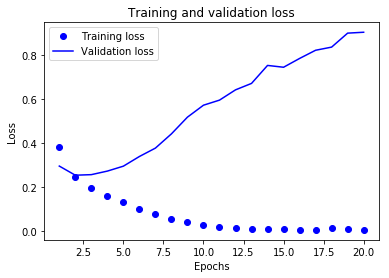

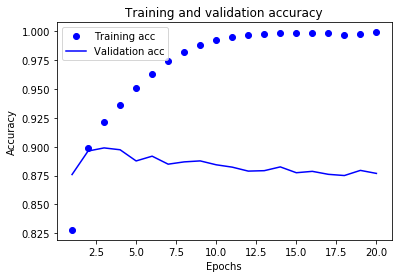

In [28]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [29]:
# evaluate the model
loss, accuracy = model.evaluate(x_val, y_val, verbose=2)
print('Accuracy validate: %f' % (accuracy*100))

Accuracy validate: 87.690974


In [30]:
import pandas
vect_range=list(range(30))
range_epoch = pandas.DataFrame(vect_range)
val_acc2 = pandas.DataFrame(val_acc)
best_acc = pandas.concat([range_epoch, val_acc2], axis=1)
best_acc.columns = ['a','b']
epoch=best_acc.loc[best_acc['b']==max(best_acc['b']),"a"]

new_epoch=int(epoch+1)
print(int(new_epoch))

3


In [31]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.layers[0].set_weights([embedding_matrix])
#model.layers[0].trainable = False

#model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=lr, decay=lr_d), metrics=["accuracy"])

model.fit(x_train, y_train,
                    epochs=new_epoch,
                    batch_size=1024,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 100)          9000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                480032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 9,480,065
Trainable params: 9,480,065
Non-trainable params: 0
_________________________________________________________________
Train on 377144 samples, validate on 185758 samples
Epoch 1/3
377144/377144 [==============================] - ETA: 4:57 - loss: 0.7657 - acc: 0.363 - ETA: 1:46 - loss: 0.8234 - acc: 0.629 - ETA: 1:08 - loss: 0.7514 - acc: 0.682 - ETA: 51s - loss: 0.6987 - acc: 0.

377144/377144 [==============================] - ETA: 15s - loss: 0.2629 - acc: 0.89 - ETA: 12s - loss: 0.2592 - acc: 0.89 - ETA: 12s - loss: 0.2593 - acc: 0.89 - ETA: 11s - loss: 0.2604 - acc: 0.89 - ETA: 11s - loss: 0.2600 - acc: 0.89 - ETA: 11s - loss: 0.2638 - acc: 0.89 - ETA: 11s - loss: 0.2628 - acc: 0.89 - ETA: 11s - loss: 0.2638 - acc: 0.89 - ETA: 11s - loss: 0.2618 - acc: 0.89 - ETA: 11s - loss: 0.2610 - acc: 0.89 - ETA: 11s - loss: 0.2597 - acc: 0.89 - ETA: 10s - loss: 0.2583 - acc: 0.89 - ETA: 10s - loss: 0.2596 - acc: 0.89 - ETA: 10s - loss: 0.2597 - acc: 0.89 - ETA: 10s - loss: 0.2595 - acc: 0.89 - ETA: 10s - loss: 0.2590 - acc: 0.89 - ETA: 10s - loss: 0.2590 - acc: 0.89 - ETA: 10s - loss: 0.2580 - acc: 0.89 - ETA: 10s - loss: 0.2570 - acc: 0.89 - ETA: 10s - loss: 0.2568 - acc: 0.89 - ETA: 10s - loss: 0.2564 - acc: 0.89 - ETA: 10s - loss: 0.2560 - acc: 0.89 - ETA: 10s - loss: 0.2552 - acc: 0.89 - ETA: 10s - loss: 0.2542 - acc: 0.89 - ETA: 10s - loss: 0.2532 - acc: 0.89 - E

377144/377144 [==============================] - ETA: 16s - loss: 0.1947 - acc: 0.91 - ETA: 12s - loss: 0.1846 - acc: 0.92 - ETA: 12s - loss: 0.1787 - acc: 0.92 - ETA: 12s - loss: 0.1797 - acc: 0.93 - ETA: 11s - loss: 0.1764 - acc: 0.93 - ETA: 11s - loss: 0.1813 - acc: 0.92 - ETA: 11s - loss: 0.1824 - acc: 0.92 - ETA: 11s - loss: 0.1846 - acc: 0.92 - ETA: 11s - loss: 0.1843 - acc: 0.92 - ETA: 11s - loss: 0.1842 - acc: 0.92 - ETA: 11s - loss: 0.1861 - acc: 0.92 - ETA: 11s - loss: 0.1872 - acc: 0.92 - ETA: 11s - loss: 0.1870 - acc: 0.92 - ETA: 11s - loss: 0.1877 - acc: 0.92 - ETA: 11s - loss: 0.1881 - acc: 0.92 - ETA: 10s - loss: 0.1883 - acc: 0.92 - ETA: 10s - loss: 0.1880 - acc: 0.92 - ETA: 10s - loss: 0.1884 - acc: 0.92 - ETA: 10s - loss: 0.1878 - acc: 0.92 - ETA: 10s - loss: 0.1866 - acc: 0.92 - ETA: 10s - loss: 0.1866 - acc: 0.92 - ETA: 10s - loss: 0.1862 - acc: 0.92 - ETA: 10s - loss: 0.1865 - acc: 0.92 - ETA: 10s - loss: 0.1859 - acc: 0.92 - ETA: 10s - loss: 0.1859 - acc: 0.92 - E

In [32]:
# evaluate the model
loss, accuracy = model.evaluate(x_train, y_train, verbose=2)
print('Accuracy train: %f' % (accuracy*100))

# evaluate the model
loss, accuracy = model.evaluate(x_val, y_val, verbose=2)
print('Accuracy validate: %f' % (accuracy*100))

Accuracy train: 93.988768
Accuracy validate: 89.879844


In [33]:
# evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print('Accuracy test: %f' % (accuracy*100))

Accuracy test: 89.751379


In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#### validation scores

In [35]:
 
# predict probabilities for test set
yhat_probs = model.predict(x_val, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(x_val, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
 


In [36]:

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, yhat_classes)
print('F1 score: %f' % f1)
 

Accuracy: 0.898798
Precision: 0.823495
Recall: 0.714629
F1 score: 0.765209


#### Train scores

In [37]:
# predict probabilities for test set
yhat_probs = model.predict(x_train, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(x_train, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
 

In [38]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, yhat_classes)
print('F1 score: %f' % f1)
 

Accuracy: 0.939888
Precision: 0.906122
Recall: 0.824988
F1 score: 0.863654


#### test scores

In [39]:
# predict probabilities for test set
yhat_probs = model.predict(x_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(x_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
 

In [40]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
 

Accuracy: 0.897514
Precision: 0.818752
Recall: 0.713919
F1 score: 0.762751
